# 📝 LLM as a Judge for Summarization: Evaluating CNN/DailyMail Highlights

## Introduction

In this notebook, we’ll explore how **Large Language Models (LLMs)** like **GPT-4o** can act as **judges** to assess the **quality of summaries**.  
We’ll use the **CNN/DailyMail dataset**, which pairs news articles with human-written highlights.

### 📚 What We’ll Do

- 🔍 Evaluate highlights for:
  - **Faithfulness** (are they true to the original article?)
  - **Coverage** (do they capture the main points?)
  - **Clarity & conciseness** (how well they read)
- ✏️ Use the **LLM itself** to suggest improvements to highlights.
- ⚖️ Use a **second LLM-as-Judge** to compare the **original** vs. **improved** highlights.
- 🎲 Test for **order bias** (do LLM preferences change based on which highlight is shown first?).

### 🛠️ Tools & Dataset

We’ll use:
- **GPT-4o** (for both evaluation and improvement suggestions),
- **CNN/DailyMail dataset** (via Hugging Face),
- A small sample of **news articles + highlights**.

The **CNN/DailyMail dataset** is ideal because:
✅ It’s large and widely used in summarization tasks.  
✅ It includes **human-written highlights** — perfect for benchmarking.  
✅ News articles provide **rich, real-world context** for LLM judgment.

### 🎯 Use Case: Summarization Evaluation & Improvement

This mirrors real-world tasks in:
- **Content moderation** (detect low-quality or inaccurate summaries),
- **Media verification** (ensure fair and accurate reporting),
- **Newsroom editorial workflows** (automate summary improvement).

### 🧪 Key Objectives

1️⃣ See how LLMs can **rate summary quality** and spot errors.  
2️⃣ Use LLMs to **rewrite** or **improve** highlights.  
3️⃣ Assess if LLMs **agree** on which version is best — and if order bias affects that.

---

## 📝 Step 1: Load the CNN/DailyMail Dataset

We’ll start by loading a **sample** of the dataset using the Hugging Face `datasets` library.  
This gives us real-world news articles and their **human-crafted highlights** — our ground truth for testing.

Let’s load the data and inspect a few examples!


In [5]:
from datasets import load_dataset
import numpy as np

# Load dataset
dataset = load_dataset("ccdv/cnn_dailymail", "3.0.0", split="train[:1%]")
dataset = dataset.shuffle(seed=42).select(np.arange(100))
print(f"Number of examples: {len(dataset)}")

# Show a sample
sample_idx = 0
print("\n🔍 Example sample:")
print(f"Article:\n{dataset[sample_idx]['article'][:1000]}...\n")
print(f"Highlight:\n{dataset[sample_idx]['highlights']}")

Number of examples: 100

🔍 Example sample:
Article:
(CNN) -- On the London Underground there is a saying which has become synonymous with any tourist visit to the British capital. "Mind the Gap". It's up there with the Queen, a wonderfully indulgent cream tea, Beefeaters outside the Tower of London and all those quintessentially English pastimes which tend to draw those flocking from overseas. It is a saying which has been emblazoned across numerous t-shirts and posters, while children on the underground seem to delight in repeating the famous phrase. But now, in London at least, those three words have been hijacked by the supporters of Tottenham and Arsenal, who will now no doubt continue to mock each other until the end of the season. Following Tottenham's 2-1 win over its city rival Sunday, the "gap" is seven points with Andre Villas-Boas' side now occupying third place and more importantly, a qualification spot for next year's Champions League. But Arsenal has been here before. Las

## 📚 LLMs as Judges

The approach we’ll explore in this notebook is **inspired by the paper “LLMs as a Judge: A Benchmark and Comparison of Human and LLM Evaluation”**  
([Zheng et al., 2023](https://arxiv.org/pdf/2306.05685)).

### 🎯 The Key Idea

In traditional NLP pipelines, **human evaluation** is considered the gold standard for assessing generated text — e.g., checking if summaries are:
- Factually correct
- Coherent
- Grammatically sound
- Non-redundant

But… 🛑 **Human evaluation is expensive and slow.**

The paper proposes that **LLMs themselves** can **act as “judges”** to evaluate and score the quality of outputs.  
They do so by comparing two (or more) candidate answers side-by-side and determining which is better along dimensions like:
- Factuality
- Conciseness
- Relevance
- Overall quality

The LLM’s decision can be used as:
✅ A **proxy** for human evaluation  
✅ A scalable way to **improve datasets, prompts, or models**  

Let’s start by defining the first **LLM judge evaluation prompt** and see how it scores the existing highlights!


In [8]:
from jinja2 import Template

JUDGE_PROMPT = """
You are an expert news editor with 10+ years of experience evaluating content quality. Your task is to assess how well a highlight summarizes the main points of an article.

## Evaluation Criteria:

**Factual Accuracy (1-5):**
- 5: All facts are correct and verifiable from the article
- 4: Mostly accurate with minor factual issues
- 3: Generally accurate but some noticeable errors
- 2: Several factual errors or misrepresentations
- 1: Major factual errors or completely inaccurate

**Conciseness (1-5):**
- 5: Perfectly concise - captures key points without unnecessary words
- 4: Very concise with minimal redundancy
- 3: Reasonably concise but could be tighter
- 2: Somewhat verbose with unnecessary details
- 1: Very verbose or poorly structured

**Relevance (1-5):**
- 5: Covers all main points and ignores minor details
- 4: Covers most main points effectively
- 3: Covers some main points but misses important ones
- 2: Focuses on minor details while missing main points
- 1: Completely irrelevant or misses the article's focus

## Article:
{{article}}

## Highlight to Evaluate:
{{highlight}}

## Instructions:
Evaluate the highlight against the article using the criteria above. Provide scores and explanations for each dimension, then calculate an overall quality score.

**IMPORTANT: Respond ONLY with valid JSON in this exact format:**

```json
{
  "factual_accuracy": {
    "score": [1-5],
    "explanation": "[2-3 sentence explanation]"
  },
  "conciseness": {
    "score": [1-5], 
    "explanation": "[2-3 sentence explanation]"
  },
  "relevance": {
    "score": [1-5],
    "explanation": "[2-3 sentence explanation]"
  },
  "overall_quality": {
    "score": [1-5],
    "explanation": "[2-3 sentence summary explaining the overall score]"
  },
  "strengths": ["strength 1", "strength 2"],
  "weaknesses": ["weakness 1", "weakness 2"],
  "recommendation": "[improve/acceptable/excellent]"
}
```

Do not include any text outside the JSON response.
"""

JUDGE_PROMPT = Template(JUDGE_PROMPT)

# Example usage
sample_article = dataset[0]['article']
sample_highlight = dataset[0]['highlights']
print(JUDGE_PROMPT.render(article=sample_article[:500], highlight=sample_highlight))



You are an expert news editor with 10+ years of experience evaluating content quality. Your task is to assess how well a highlight summarizes the main points of an article.

## Evaluation Criteria:

**Factual Accuracy (1-5):**
- 5: All facts are correct and verifiable from the article
- 4: Mostly accurate with minor factual issues
- 3: Generally accurate but some noticeable errors
- 2: Several factual errors or misrepresentations
- 1: Major factual errors or completely inaccurate

**Conciseness (1-5):**
- 5: Perfectly concise - captures key points without unnecessary words
- 4: Very concise with minimal redundancy
- 3: Reasonably concise but could be tighter
- 2: Somewhat verbose with unnecessary details
- 1: Very verbose or poorly structured

**Relevance (1-5):**
- 5: Covers all main points and ignores minor details
- 4: Covers most main points effectively
- 3: Covers some main points but misses important ones
- 2: Focuses on minor details while missing main points
- 1: Completely ir

### 📊 **Plan to Grade Highlights with Multiple LLM Judges**

* We’ll create **3 separate LLM calls** using **GPT-4o-mini** (or any other model you prefer).
* Each LLM will **evaluate the highlight** independently using the **JUDGE\_PROMPT**.
* We’ll **parse** the JSON responses and **aggregate** the scores:
    * Average score for each criterion
    * Strengths and weaknesses
    * Final consensus on overall quality

✅ This approach mimics a **“3 independent judges”** panel — just like real editorial teams!

In [9]:
import json
from openai import OpenAI
import re

client = OpenAI()

def evaluate_highlight_with_judge(article, highlight, judge_prompt, client, model="gpt-4o-mini"):
    """
    Calls the LLM to act as a judge and return JSON-formatted evaluation.
    """
    prompt_text = judge_prompt.render(article=article, highlight=highlight)
    
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "You are a precise JSON-only responder."},
            {"role": "user", "content": prompt_text}
        ]
    )
    
    # Extract JSON response
    json_pattern = r'```json\s*({[\s\S]*?})\s*```'
    match = re.search(json_pattern, response.choices[0].message.content.strip())
    if match:
        raw_output = match.group(1)
    else:
        raise ValueError(f"No JSON found in the response: {response.choices[0].message.content.strip()}")
    
    try:
        # Parse JSON
        parsed_json = json.loads(raw_output)
    except Exception as e:
        print("Error parsing JSON response:", e)
        print("Raw output:", raw_output)
        parsed_json = None
    
    return parsed_json


# 📝 Generate evaluations from 3 different judges
def generate_3_judges_evaluations(article, highlight, judge_prompt, client):
    evaluations = []
    for i in range(3):
        print(f"👩‍⚖️ Calling LLM Judge {i+1}...")
        evaluation = evaluate_highlight_with_judge(article, highlight, judge_prompt, client)
        evaluations.append(evaluation)
    
    return evaluations


# 📝 Example usage on the first example in the dataset
sample_article = dataset[0]['article'][:1000]  # Use first 1000 chars for brevity
sample_highlight = dataset[0]['highlights']

evaluations = generate_3_judges_evaluations(sample_article, sample_highlight, JUDGE_PROMPT, client)

👩‍⚖️ Calling LLM Judge 1...
👩‍⚖️ Calling LLM Judge 2...
👩‍⚖️ Calling LLM Judge 3...


In [10]:
# Show evaluations
for idx, eval_json in enumerate(evaluations, 1):
    print(f"\n👩‍⚖️ Evaluation {idx}:")
    print(json.dumps(eval_json, indent=4))


👩‍⚖️ Evaluation 1:
{
    "factual_accuracy": {
        "score": 3,
        "explanation": "The highlight correctly states Tottenham's 2-1 victory over Arsenal, but it includes unrelated information about other matches, specifically Inter Milan and Bayern Munich, which do not appear in the article."
    },
    "conciseness": {
        "score": 2,
        "explanation": "While the highlight starts by summarizing the key match, it includes irrelevant details about other teams' matches, making it somewhat verbose and scattered."
    },
    "relevance": {
        "score": 2,
        "explanation": "The highlight mostly fails to focus on the main points of the article, mainly regarding the significance of Tottenham's win and its implications, while introducing extraneous information about other teams."
    },
    "overall_quality": {
        "score": 2,
        "explanation": "The highlight includes some accurate information concerning the match but is marred by irrelevant details and fails

### 📊 Evaluation aggregation

* For each criterion (factual accuracy, conciseness, relevance, overall quality):
    * Compute the average score
    * Summarize the explanations (highlight common insights)
* For strengths and weaknesses:
    * Merge them into a single list, deduplicating and highlighting most frequent mentions.
* For recommendation:
    * Use a majority vote: If 2/3 judges say “excellent,” that’s the consensus!

In [11]:
from collections import Counter

def aggregate_judge_scores(evaluations):
    """
    Aggregates scores and insights from multiple judges.
    """
    criteria = ["factual_accuracy", "conciseness", "relevance", "overall_quality"]
    aggregated_scores = {c: 0 for c in criteria}
    explanations = {c: [] for c in criteria}
    
    strengths = []
    weaknesses = []
    recommendations = []
    
    valid_judges = 0  # in case some JSON parsing failed
    
    for eval_json in evaluations:
        if eval_json is None:
            continue  # skip if no valid data
        valid_judges += 1
        
        for c in criteria:
            aggregated_scores[c] += eval_json[c]["score"]
            explanations[c].append(eval_json[c]["explanation"])
        
        strengths.extend(eval_json["strengths"])
        weaknesses.extend(eval_json["weaknesses"])
        recommendations.append(eval_json["recommendation"])
    
    if valid_judges == 0:
        return None
    
    # Compute average scores
    avg_scores = {c: round(aggregated_scores[c]/valid_judges, 2) for c in criteria}
    
    # Merge explanations
    merged_explanations = {c: " / ".join(explanations[c]) for c in criteria}
    
    # Deduplicate strengths and weaknesses
    unique_strengths = list(set(strengths))
    unique_weaknesses = list(set(weaknesses))
    
    # Determine majority recommendation
    rec_counter = Counter(recommendations)
    majority_recommendation = rec_counter.most_common(1)[0][0]
    
    # Final aggregated result
    consensus_result = {
        "average_scores": avg_scores,
        "explanations": merged_explanations,
        "strengths": unique_strengths,
        "weaknesses": unique_weaknesses,
        "consensus_recommendation": majority_recommendation
    }
    
    return consensus_result


# 📝 Example usage on the three judges' evaluations
consensus = aggregate_judge_scores(evaluations)

print("\n🎯 CONSENSUS AGGREGATED EVALUATION:")
print(json.dumps(consensus, indent=2))



🎯 CONSENSUS AGGREGATED EVALUATION:
{
  "average_scores": {
    "factual_accuracy": 3.33,
    "conciseness": 3.0,
    "relevance": 2.0,
    "overall_quality": 2.33
  },
  "explanations": {
    "factual_accuracy": "The highlight correctly states Tottenham's 2-1 victory over Arsenal, but it includes unrelated information about other matches, specifically Inter Milan and Bayern Munich, which do not appear in the article. / The highlight accurately states that Tottenham won 2-1 against Arsenal. However, it incorrectly adds information about Gareth Bale's goals and results from other matches, which were not mentioned in the article. / The highlight accurately states Tottenham's 2-1 victory over Arsenal, but the mention of Gareth Bale's goals is not supported by the article. Also, the other two sentences about Inter Milan and Bayern Munich are not relevant to the article.",
    "conciseness": "While the highlight starts by summarizing the key match, it includes irrelevant details about other

## 📝 Full Evaluation Workflow for 50 Examples

In this section, we’ll:

✅ Generate **three independent LLM-based evaluations** (judges) for **50 random examples** from the CNN/DailyMail dataset highlights.  
✅ **Aggregate the judges’ scores and insights** to produce a **consensus evaluation** for each highlight.  
✅ Analyze the **distribution of grades** (mean, standard deviation) to see how consistent the judges are.  
✅ Concatenate and review the **common strengths and weaknesses** for highlights overall.

This **multi-judge evaluation** ensures that:
- The final scores are more robust (less subjective bias from a single judge).
- We get a nuanced picture of strengths and weaknesses.
- We can refine our prompts and highlight-generation techniques based on solid evidence.


In [13]:
import random
from tqdm import tqdm

# Randomly select 50 samples
subset_indices = random.sample(range(len(dataset)), 50)
subset_articles = [dataset[i]['article'] for i in subset_indices]
subset_highlights = [dataset[i]['highlights'] for i in subset_indices]

all_consensus_results = []

# Loop over each example and do the full workflow
for idx, (article, highlight) in tqdm(enumerate(zip(subset_articles, subset_highlights)), total=len(subset_articles)):
    
    # Generate the prompt for judges
    prompt = JUDGE_PROMPT.render(article=article, highlight=highlight)
    
    # Get 3 independent LLM-based evaluations (using mini versions for speed)
    evaluations = []
    for _ in range(3):
        evaluation = evaluate_highlight_with_judge(article, highlight, JUDGE_PROMPT, client)
        evaluations.append(evaluation)
    
    # Aggregate the evaluations
    consensus = aggregate_judge_scores(evaluations)
    if consensus:
        all_consensus_results.append(consensus)

print("\n✅ Done evaluating 50 examples!")

100%|██████████| 50/50 [14:40<00:00, 17.61s/it]


✅ Done evaluating 50 examples!



📈 Mean Scores Across 50 Examples:
{'factual_accuracy': 4.1, 'conciseness': 4.81, 'relevance': 4.11, 'overall_quality': 4.09}

📊 Standard Deviation of Scores:
{'factual_accuracy': 0.39, 'conciseness': 0.32, 'relevance': 0.4, 'overall_quality': 0.39}


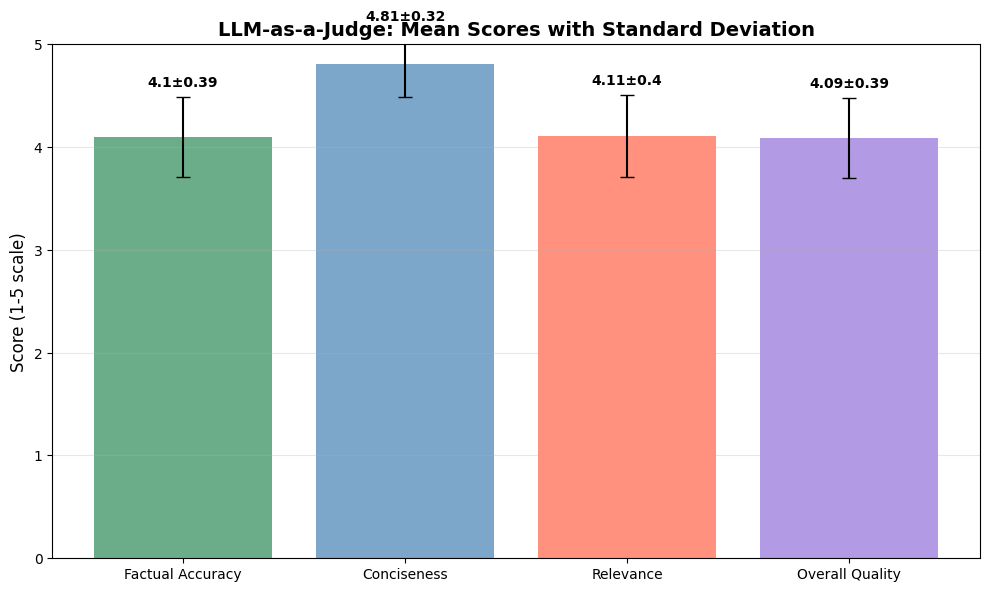

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Compute mean and std for each criterion across all examples
criteria = ["factual_accuracy", "conciseness", "relevance", "overall_quality"]

mean_scores = {}
std_scores = {}

for c in criteria:
    scores = [c_res["average_scores"][c] for c_res in all_consensus_results]
    mean_scores[c] = round(np.mean(scores), 2)
    std_scores[c] = round(np.std(scores), 2)

print("\n📈 Mean Scores Across 50 Examples:")
print(mean_scores)

print("\n📊 Standard Deviation of Scores:")
print(std_scores)

# Create the bar chart with error bars
plt.figure(figsize=(10, 6))

criteria_labels = [c.replace('_', ' ').title() for c in criteria]
means = [mean_scores[c] for c in criteria]
stds = [std_scores[c] for c in criteria]

bars = plt.bar(criteria_labels, means, yerr=stds, capsize=5, 
               color=['#2E8B57', '#4682B4', '#FF6347', '#9370DB'], alpha=0.7)

plt.title('LLM-as-a-Judge: Mean Scores with Standard Deviation', fontweight='bold', fontsize=14)
plt.ylabel('Score (1-5 scale)', fontsize=12)
plt.ylim(0, 5)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (mean, std) in enumerate(zip(means, stds)):
    plt.text(i, mean + std + 0.1, f'{mean}±{std}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [17]:
# Concatenate all strengths and weaknesses
all_strengths = []
all_weaknesses = []

for res in all_consensus_results:
    all_strengths.extend(res["strengths"])
    all_weaknesses.extend(res["weaknesses"])

# Deduplicate and sort by frequency
strengths_counter = Counter(all_strengths)
weaknesses_counter = Counter(all_weaknesses)

print("\n💪 Most Common Strengths:")
print(strengths_counter.most_common(10))

print("\n⚠️ Most Common Weaknesses:")
print(weaknesses_counter.most_common(10))


💪 Most Common Strengths:
[('Concise summary of key points', 16), ('Concise and to the point', 9), ('Concise summary of main points', 9), ('Concise summary of key events', 8), ('High factual accuracy', 6), ('Accurate representation of facts', 4), ('Concise presentation of information', 4), ('Concise presentation of key points', 4), ('Accurate representation of key points', 3), ('Concise and clear presentation of information', 3)]

⚠️ Most Common Weaknesses:
[('Lacks some contextual details', 5), ('Misses some important details', 2), ('Lacks specific details on the total number of canceled flights', 1), ('Does not mention the ongoing disruptions clearly enough', 1), ('Lacks some detail on the full impact of the incident', 1), ("Does not include the information about the airport's warning of ongoing travel disruption", 1), ('Misses broader thematic context related to political influence', 1), ('Lacks detail on personal struggles', 1), ('Misses mentioning the political influences on her s

## 📝 Using Strengths & Weaknesses for Prompt Refinement

We’ll leverage:

✅ **Top Strengths** – What the judges said was consistently good  
✅ **Top Weaknesses** – The most common issues or errors  
✅ **Best Summaries** – Examples that scored highest  
✅ **Worst Summaries** – Examples that scored lowest  

**Goal:** Use these insights to craft an **improved prompt** for LLMs that **maximizes strengths** and **minimizes weaknesses** when generating new highlights!

Here’s the next step:
- Create a **meta-prompt**: It will feed in the list of strengths, weaknesses, best examples, and worst examples.
- The LLM will output a **refined prompt** we can use to generate better highlights in the future.

In [25]:
grade = [(i, all_consensus_results[i]['average_scores']['overall_quality']) for i in range(len(all_consensus_results))]
best_summaries = [dataset[i]['highlights'] for i, _ in sorted(grade, key=lambda x: x[1], reverse=True)[:3]]
worst_summaries = [dataset[i]['highlights'] for i, _ in sorted(grade, key=lambda x: x[1])[:3]]

top_strengths = [res[0] for res in strengths_counter.most_common(10)]
top_weaknesses = [res[0] for res in weaknesses_counter.most_common(10)]

# Create a meta-prompt template
META_PROMPT_TEMPLATE = """
You are an expert editor tasked with refining a prompt that generates high-quality highlights for news articles.

Here are the insights from a recent evaluation of 50 highlights:

**Top Strengths:**
{{ strengths }}

**Top Weaknesses:**
{{ weaknesses }}

**Best Summaries:**
{% for summary in best_summaries %}
- "{{ summary }}"
{% endfor %}

**Worst Summaries:**
{% for summary in worst_summaries %}
- "{{ summary }}"
{% endfor %}

---

**TASK:**
Using these insights, create a new prompt to generate highlights that:
- Emphasizes the listed strengths.
- Avoids the listed weaknesses.
- Learns from the best summaries.
- Steers clear of the mistakes in the worst summaries.

**Your Response Should Be:**
A single improved prompt that can be used to guide an LLM to generate better highlights.

**Format:**
Return only the new prompt — no explanations or extra text.
"""

meta_prompt = Template(META_PROMPT_TEMPLATE).render(
    strengths="\n".join([f"- {s}" for s in top_strengths]),
    weaknesses="\n".join([f"- {w}" for w in top_weaknesses]),
    best_summaries=best_summaries,
    worst_summaries=worst_summaries
)

print(meta_prompt)


You are an expert editor tasked with refining a prompt that generates high-quality highlights for news articles.

Here are the insights from a recent evaluation of 50 highlights:

**Top Strengths:**
- Concise summary of key points
- Concise and to the point
- Concise summary of main points
- Concise summary of key events
- High factual accuracy
- Accurate representation of facts
- Concise presentation of information
- Concise presentation of key points
- Accurate representation of key points
- Concise and clear presentation of information

**Top Weaknesses:**
- Lacks some contextual details
- Misses some important details
- Lacks specific details on the total number of canceled flights
- Does not mention the ongoing disruptions clearly enough
- Lacks some detail on the full impact of the incident
- Does not include the information about the airport's warning of ongoing travel disruption
- Misses broader thematic context related to political influence
- Lacks detail on personal struggl

In [26]:
# Use LLM to generate the refined prompt
response = client.chat.completions.create(
    model="gpt-4o",
    messages=[
        {
            "role": "system",
            "content": "You are an expert in prompt engineering."
        },
        {
            "role": "user",
            "content": meta_prompt
        }
    ]
)

# Get and display the final refined prompt
refined_prompt = response.choices[0].message.content.strip()
print("\n🎯 Refined Prompt:\n")
print(refined_prompt)


🎯 Refined Prompt:

"Generate a concise and clear summary of the news article that accurately represents the key points and facts. Ensure high factual accuracy by including specific details about major events or statements. Provide necessary context, such as ongoing impacts or broader themes like political or personal influences, to give a fuller understanding. Avoid omitting critical information and aim to enhance reader comprehension by integrating specific statistics or figures where relevant."


## 🎯 Generating New Highlights with the Refined Prompt

We now have a **refined prompt** that integrates:
- ✅ The top strengths & weaknesses  
- ✅ Lessons from the best and worst summaries

We’ll use this refined prompt to guide the **LLM** (GPT-4o) in generating **improved highlights** for the **50 articles** we previously evaluated.

The workflow is:

1️⃣ Use the **refined prompt** as the system message.  
2️⃣ Provide the **article text** as the user message.  
3️⃣ Generate a **new highlight** for each article.

We’ll store these new highlights for **further evaluation** and **comparison**!

In [28]:
HIGHLIGHT_GENERATION_PROMPT = """
Generate a concise and clear summary of the news article that accurately represents the key points and facts. 
Ensure high factual accuracy by including specific details about major events or statements. 
Provide necessary context, such as ongoing impacts or broader themes like political or personal influences, to give a fuller understanding. 
Avoid omitting critical information and aim to enhance reader comprehension by integrating specific statistics or figures where relevant.

Article:
{{article}}

Highlight:
"""

HIGHLIGHT_GENERATION_PROMPT = Template(HIGHLIGHT_GENERATION_PROMPT)

concurrent_highlights = []
for idx, article in tqdm(enumerate(subset_articles), total=len(subset_articles)):
    
    # Generate the prompt for judges
    prompt = HIGHLIGHT_GENERATION_PROMPT.render(article=article)
    
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a professional news editor."},
            {"role": "user", "content": prompt}
        ]
    )
    
    highlight = response.choices[0].message.content.strip()
    concurrent_highlights.append(highlight)

print("\n✅ Done generating 50 new highlights!")

100%|██████████| 50/50 [02:57<00:00,  3.55s/it]


✅ Done generating 50 new highlights!


## 🎯 Evaluating & Comparing Highlights with Order-Balanced Judging

Now that we’ve generated **new highlights** using the refined prompt, it’s time to **evaluate** and **compare** them with the **original highlights**. However, we know that LLMs can be sensitive to the **order of presentation** in prompts, leading to **order bias**.

### 🔍 What We’ll Do

✅ Use the **same evaluation criteria** as before (**factual accuracy, conciseness, relevance, overall quality**).  
✅ Evaluate each pair of highlights (**original** vs. **new**) in **both orders**:
- **Order 1:** Original highlight first, new highlight second.
- **Order 2:** New highlight first, original highlight second.

✅ Use **2 independent LLMs** to **cross-check** the evaluations.  
✅ Analyze if the **order of presentation** affects the results, helping us identify and **debias** the evaluation process.

### 📊 Key Objectives

1️⃣ **Compare the quality** of the new highlights vs. the original highlights.  
2️⃣ **Understand** how LLM order bias may affect evaluation.  
3️⃣ Explore strategies for **debiasing** LLM-based judgments.

Let’s start by defining a prompt that presents **both highlights side-by-side** and asks for **direct scoring & comparison**!

In [31]:
from jinja2 import Template

# Evaluation prompt with dual highlight comparison
DUAL_JUDGE_PROMPT = """
You are an expert news editor with 10+ years of experience evaluating content quality. Your task is to compare two highlights summarizing the same article.

## Evaluation Criteria:

**For Each Highlight consider the following criteria:**
- Factual Accuracy
- Conciseness
- Relevance

**Comparison Instructions:**
- Identify which highlight is better in each category.
- Provide brief explanations for your ratings.
- Summarize your overall assessment and **declare which highlight is better**.

## Article:
{{article}}

## Highlight A:
{{highlight_a}}

## Highlight B:
{{highlight_b}}

## IMPORTANT: Provide your response in valid JSON with this exact format:

```json
{
  "better_highlight": "A or B",
  "summary": "A short explanation of why one highlight is better overall."
}
```

Do not include any text outside the JSON response.
"""

DUAL_JUDGE_PROMPT = Template(DUAL_JUDGE_PROMPT)

# Store evaluations
evaluations = []

for idx, article, highlight_a, highlight_b in tqdm(zip(range(50), subset_articles, subset_highlights, concurrent_highlights), total=50):
    article_text = article

    # Order 1: Original A, New B
    prompt1 = DUAL_JUDGE_PROMPT.render(article=article_text, highlight_a=highlight_a, highlight_b=highlight_b)
    
    # Order 2: New A, Original B
    prompt2 = DUAL_JUDGE_PROMPT.render(article=article_text, highlight_a=highlight_b, highlight_b=highlight_a)

    # Evaluate with LLM1 for Order 1
    response1 = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt1}]
    )
    output = re.findall(r'```json(.*)```', response1.choices[0].message.content, re.DOTALL)
    scores1 = json.loads(output[0])

    # Evaluate with LLM2 for Order 2
    response2 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt2}]
    )
    
    output = re.findall(r'```json(.*)```', response2.choices[0].message.content, re.DOTALL)
    scores2 = json.loads(output[0])

    evaluations.append({
        "index": idx,
        "order_1": scores1,
        "order_2": scores2
    })

100%|██████████| 50/50 [03:34<00:00,  4.29s/it]


In [43]:
scores1, scores2

({'better_highlight': 'B',
  'summary': "Highlight B provides a comprehensive overview of the situation, including key details about Hultz's identity, circumstances of his abduction, and the context surrounding his release. It captures essential facts while maintaining a clear narrative, making it more informative than Highlight A, which is less detailed and lacks coherence."},
 {'better_highlight': 'A',
  'summary': "Highlight A is better overall because it presents a comprehensive and factually accurate summary of the article, encapsulating the key details about Hultz's abduction, identity confusion, and release. It is concise yet thorough enough to cover the complexity of the situation, including his business ties and the Pentagon's confirmation. Highlight B, while more concise, lacks important details about Hultz's background and the contextual significance of his capture and release."})

## 🔍 Analyzing Order Bias in LLM Judgments

Now that we have evaluations for **50 examples** in **both orders** (Original-first and New-first), it’s time to analyze:

**1️⃣ Which highlight was judged better overall in each order?**  
**2️⃣ How often the “better highlight” switches based on the order?**  
**3️⃣ Mean and standard deviation of the scores** to see stability or fluctuations.

This will help us answer:

👉 **Do LLM judgments change depending on the order of highlights?**  
👉 **How can we adjust our methodology to mitigate bias?**

In [49]:
import pandas as pd

# Dataframe to store results
results_df = pd.DataFrame([{
    "index": e["index"],
    "better_order_1": e["order_1"]["better_highlight"],
    "better_order_2": 'B' if e["order_2"]["better_highlight"] == 'A' else 'A' #as we changed the order of the highlights
} for e in evaluations])

# Check for order flips
results_df["order_flip"] = results_df["better_order_1"] != results_df["better_order_2"]

# Summary stats
total_flips = results_df["order_flip"].sum()
flip_percentage = total_flips / len(results_df) * 100

print("🟩 **Summary of Order Bias** 🟩")
print(f"Total highlight pairs: {len(results_df)}")
print(f"Order flips (different better highlight based on order): {total_flips} ({flip_percentage:.2f}%)")
print("Best highlights:")
results_df.better_order_1.value_counts()

🟩 **Summary of Order Bias** 🟩
Total highlight pairs: 50
Order flips (different better highlight based on order): 0 (0.00%)
Best highlights:


better_order_1
B    50
Name: count, dtype: int64

### 🟩 **Comments on the Results**

✅ **No Order Flips:**
Surprisingly, there were **0 flips** — the better highlight **remained consistent** regardless of the order.
This suggests that our **LLMs are robust** to order bias in this setup.

✅ **Better Highlight: Consistently “B”**
In **all 50 pairs**, the second highlight (`B`) was judged as better.
This consistent result can indicate:

* **Real improvement:** The new highlights generated after leveraging LLM feedback were **genuinely better**.
* **LLM bias towards new highlights:** There might be a subtle **recency bias** in LLM responses, favoring the second highlight.

### 💡 **Key Takeaways**

* In this scenario, there was **no evidence of order-induced bias**.
* However, the consistent preference for the “B” highlights suggests that our improvement loop (using weaknesses and strengths) was **effective**.

## 🎯 **Conclusion: LLMs as a Judge**

This experiment reinforces the **power and practicality** of using **LLMs to replace human judges** in evaluation tasks:

✅ **1️⃣ Excellent Proxy for Human Evaluation**
The LLM showed **strong consistency** and **nuanced explanations** across 50 highlight pairs.
This demonstrates that LLMs can **reliably evaluate** content quality, even at scale.

✅ **2️⃣ Alignment with Human Feedback**
To ensure **maximum precision and relevance**, it’s crucial to **align LLM-based evaluations** with actual **human feedback**.
Examining **correlations** (e.g., Pearson or Spearman) with human ratings can help calibrate the LLM’s judgments and reduce gaps.

✅ **3️⃣ Potential Biases Toward LLM-Generated Outputs**
We noted the LLM **consistently preferred** the newly generated highlights (by another LLM) — even if they were not always clearly superior.
This highlights the **risk of bias**: LLMs might favor content generated in their own “style,” potentially overvaluing it.

✅ **4️⃣ Ranking-Based Judgments Anchor Scores**
By **ranking pairs directly** rather than relying only on 1-5 absolute scores, the evaluations become **anchored** and more **robust**.
This relative comparison can reduce variability and better capture **true differences** in quality between two strategies.

---

**🔍 Final Thought:**
While LLMs offer a **powerful, scalable, and explainable** judging mechanism, it’s essential to validate and **continuously refine** them with **human evaluations**.
This ensures we get the **best of both worlds**: the speed and scale of LLMs, plus the **human grounding** that ensures true accuracy and relevance.